<a href="https://colab.research.google.com/github/vamshigaddi/YOLOv8-Custom_Object-_Detection_Project/blob/main/YOLOV8_obj_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install roboflow
!pip install ultralytics

 **Downloading Data from Roboflow**

**Rocks dataset**

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="nPxJMJqWZlqzuf83QEHB")
project = rf.workspace("project-creo0").project("rock-u9jtp")
version = project.version(3)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.34, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to rock-3 in yolov8:: 100%|██████████| 1812/1812 [00:00<00:00, 7381.07it/s]


**Plastic_box dataset**

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="nPxJMJqWZlqzuf83QEHB")
project = rf.workspace("nacho-ls03j").project("detect-bins")
version = project.version(2)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.34, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to detect-bins-2 in yolov8:: 100%|██████████| 1508/1508 [00:00<00:00, 8944.93it/s]


**Changing classes of label from 0 to 1**

In [ ]:
import os

def change_rocks_classes(rocks_dir):
    # Iterate through each data split (train, valid, test)
    for data_split in ["train", "valid", "test"]:
        src_label_dir = os.path.join(rocks_dir, data_split, "labels")

        # Change class labels to 1 for rocks
        for label_file in os.listdir(src_label_dir):
            if label_file.endswith('.txt'):
                label_file_path = os.path.join(src_label_dir, label_file)
                with open(label_file_path, 'r+') as f:
                    lines = f.readlines()
                    modified_lines = [line.replace('0 ', '1 ') for line in lines]
                    f.seek(0)
                    f.writelines(modified_lines)
                    f.truncate()

# Define directory for rocks dataset
rocks_dir = "/content/rock-3"

# Change class labels for rocks dataset
change_rocks_classes(rocks_dir)

print("Class labels changed for the 'rocks' dataset!")


Class labels changed for the 'rocks' dataset!


# **Combining both datasets**

In [ ]:
import os
import shutil
import yaml

def create_directory_structure(output_dir):
    # Create train, valid, and test directories
    for split in ["train", "valid", "test"]:
        split_dir = os.path.join(output_dir, split)
        os.makedirs(split_dir, exist_ok=True)
        os.makedirs(os.path.join(split_dir, "images"), exist_ok=True)
        os.makedirs(os.path.join(split_dir, "labels"), exist_ok=True)

def combine_datasets(dataset_dirs, output_dir):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    print("Combined dataset directory created successfully at:", output_dir)

    # Create directory structure for train, valid, and test
    create_directory_structure(output_dir)

    # Iterate through each dataset directory
    for dataset_dir in dataset_dirs:
        # Copy train, valid, and test data
        for data_split in ["train", "valid", "test"]:
            src_data_dir = os.path.join(dataset_dir, data_split)
            dest_data_dir = os.path.join(output_dir, data_split, "images")

            # Copy images
            for root, _, files in os.walk(src_data_dir):
                for file in files:
                    # Split file name and check extension from the right side
                    if file.split('.')[-1] == 'txt':
                        # Move label file
                        src_label_path = os.path.join(root, file)
                        dest_label_path = os.path.join(output_dir, data_split, "labels", file)
                        shutil.copy(src_label_path, dest_label_path)
                    else:
                        src_image_path = os.path.join(root, file)
                        dest_image_path = os.path.join(dest_data_dir, file)
                        shutil.copy(src_image_path, dest_image_path)

    # Create data.yaml if it doesn't exist
    if not os.path.exists(os.path.join(output_dir, "data.yaml")):
        classes = ["plastic_box", "rock"]
        data = {"train": os.path.join(output_dir, "train"), "val": os.path.join(output_dir, "valid"), "test": os.path.join(output_dir, "test"), "nc": len(classes), "names": classes}
        with open(os.path.join(output_dir, "data.yaml"), "w") as yaml_file:
            yaml.dump(data, yaml_file)

# Define directories for plastic box and rocks datasets
plastic_box_dir = "/content/detect-bins-2"
rocks_dir = "/content/rock-3"
# Define output directory for combined dataset
combined_dataset_dir = "/content/combined_dataset_01"

# Combine datasets
combine_datasets([plastic_box_dir, rocks_dir], combined_dataset_dir)

print("Combined dataset created successfully!")

Combined dataset directory created successfully at: /content/combined_dataset_01
Combined dataset created successfully!


# **Exploring dataset**

In [ ]:
import os

def count_files_in_folder(folder, extension):
    num_files = len([file for file in os.listdir(folder) if file.endswith(extension)])
    return num_files

def check_shapes(dataset_dir):
    splits = ["train", "valid", "test"]
    for split in splits:
        images_folder = os.path.join(dataset_dir, split, "images")
        labels_folder = os.path.join(dataset_dir, split, "labels")
        num_images = count_files_in_folder(images_folder, ".jpg")
        num_labels = count_files_in_folder(labels_folder, ".txt")
        print(f"{split.capitalize()} dataset:")
        print(f"Number of images: {num_images}")
        print(f"Number of label files: {num_labels}")
        print()

# Define the directory of the combined dataset
dataset_dir = "/content/combined_dataset_01"

# Check shapes of the dataset
check_shapes(dataset_dir)


Train dataset:
Number of images: 1375
Number of label files: 1375

Valid dataset:
Number of images: 153
Number of label files: 153

Test dataset:
Number of images: 120
Number of label files: 120



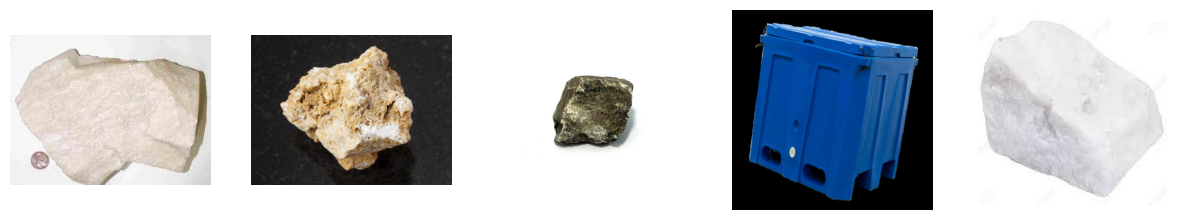

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

dataset_path='/content/combined_dataset_01/train/images'

# Get a list of image files in the dataset directory
image_files = [f for f in os.listdir(dataset_path) if f.endswith('.jpg')]

# Visualize some of the images
num_images_to_visualize = 5

# Plot the images
fig, axes = plt.subplots(1, num_images_to_visualize, figsize=(15, 3))
for i in range(num_images_to_visualize):
    # Load the image
    image_path = os.path.join(dataset_path, image_files[i])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format

    # Display the image
    axes[i].imshow(image)
    axes[i].axis('off')
    #axes[i].set_title(image_files[i])

plt.show()

# **Loading Pretrained Yolo model**

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8s.pt')  # load a pretrained model (recommended for training)

# Train the model with 2 GPUs
results = model.train(data='/content/combined_dataset_01/data.yaml', epochs=10, imgsz=224,plots=True)

100%|██████████| 21.5M/21.5M [00:00<00:00, 201MB/s]


Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/combined_dataset_01/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf

100%|██████████| 755k/755k [00:00<00:00, 23.1MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 111MB/s]


AMP: checks passed ✅


train: Scanning /content/combined_dataset_01/train/labels... 1375 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1375/1375 [00:00<00:00, 1833.75it/s]

train: New cache created: /content/combined_dataset_01/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 532, len(boxes) = 1998. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/combined_dataset_01/valid/labels... 153 images, 0 backgrounds, 0 corrupt: 100%|██████████| 153/153 [00:00<00:00, 1613.30it/s]

val: New cache created: /content/combined_dataset_01/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 76, len(boxes) = 219. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.04G     0.7867      1.202      1.089         44        224: 100%|██████████| 86/86 [00:16<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]

                   all        153        219      0.729      0.769      0.733      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10       1.1G     0.8758     0.8733      1.143         15        224: 100%|██████████| 86/86 [00:13<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.86it/s]

                   all        153        219      0.743      0.762      0.734      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10       1.1G     0.9113     0.8518      1.143         21        224: 100%|██████████| 86/86 [00:13<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.54it/s]

                   all        153        219       0.85      0.814      0.877      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10       1.1G     0.8824     0.7479      1.124         25        224: 100%|██████████| 86/86 [00:13<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]

                   all        153        219      0.848      0.832      0.896      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10       1.1G     0.8229     0.7039      1.097         28        224: 100%|██████████| 86/86 [00:13<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.10it/s]

                   all        153        219      0.897       0.84      0.894      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10       1.1G     0.8025     0.6577      1.081         18        224: 100%|██████████| 86/86 [00:13<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        153        219      0.919      0.902      0.928      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10       1.1G     0.7559     0.5791      1.061         21        224: 100%|██████████| 86/86 [00:13<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]


                   all        153        219      0.925      0.918      0.949      0.739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10       1.1G     0.7173     0.5416      1.039         17        224: 100%|██████████| 86/86 [00:13<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.20it/s]

                   all        153        219      0.955      0.847      0.943      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10       1.1G     0.6753     0.4862      1.022         34        224: 100%|██████████| 86/86 [00:13<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]

                   all        153        219      0.965       0.93      0.955      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10       1.1G      0.662     0.4485      1.006         15        224: 100%|██████████| 86/86 [00:13<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.29it/s]

                   all        153        219      0.947      0.935      0.962      0.797



10 epochs completed in 0.046 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


                   all        153        219      0.952       0.94      0.965      0.797
           plastic_box        153         99      0.937      0.899      0.938      0.703
                  rock        153        120      0.967      0.981      0.993       0.89
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train


# **Sample predictions on test images**

In [ ]:
sample_plastic_pred=model.predict('/content/combined_dataset_01/test/images/BIN-120a_jpg.rf.f93a6ab933ce8414ce7957113312f8e6.jpg',save=True)


image 1/1 /content/combined_dataset_01/test/images/BIN-120a_jpg.rf.f93a6ab933ce8414ce7957113312f8e6.jpg: 224x224 1 plastic_box, 14.4ms
Speed: 1.1ms preprocess, 14.4ms inference, 4.5ms postprocess per image at shape (1, 3, 224, 224)
Results saved to runs/detect/train2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
sample_rock_pred=model.predict('/content/combined_dataset_01/test/images/1-12-_jpg.rf.63c1b79655a216b9c498e39aed7202c9.jpg',save=True)


image 1/1 /content/combined_dataset_01/test/images/1-12-_jpg.rf.63c1b79655a216b9c498e39aed7202c9.jpg: 192x224 1 rock, 79.8ms
Speed: 1.0ms preprocess, 79.8ms inference, 2.0ms postprocess per image at shape (1, 3, 192, 224)
Results saved to runs/detect/train3
